In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pydicom
%matplotlib inline

In [3]:
ROOT_DIR = os.getcwd()
DICOM_DIR = "AllDICOMs"
MASK_DIR = "extras/MassSegmentationMasks/"

In [4]:
#DICOM names
dicom_names = os.listdir(os.path.join(ROOT_DIR, DICOM_DIR))
dicom_names.remove("inbreastBuilder.m")
dicom_names.remove("read_mixed_csv.m")
dicom_names.sort()
print(len(dicom_names))
'''
dicom_dict = {}
for dicom_name in dicom_names:
    dicom_dict[dicom_name.split("_")[0]] = dicom_name
'''
dicom_names

410


['20586908_6c613a14b80a8591_MG_R_CC_ANON.dcm',
 '20586934_6c613a14b80a8591_MG_L_CC_ANON.dcm',
 '20586960_6c613a14b80a8591_MG_R_ML_ANON.dcm',
 '20586986_6c613a14b80a8591_MG_L_ML_ANON.dcm',
 '20587054_b6a4f750c6df4f90_MG_R_CC_ANON.dcm',
 '20587080_b6a4f750c6df4f90_MG_R_ML_ANON.dcm',
 '20587148_fd746d25eb40b3dc_MG_R_CC_ANON.dcm',
 '20587174_fd746d25eb40b3dc_MG_L_CC_ANON.dcm',
 '20587200_fd746d25eb40b3dc_MG_R_ML_ANON.dcm',
 '20587226_fd746d25eb40b3dc_MG_L_ML_ANON.dcm',
 '20587294_e634830794f5c1bd_MG_R_CC_ANON.dcm',
 '20587320_e634830794f5c1bd_MG_L_CC_ANON.dcm',
 '20587346_e634830794f5c1bd_MG_R_ML_ANON.dcm',
 '20587372_e634830794f5c1bd_MG_L_ML_ANON.dcm',
 '20587466_d571b5880ad2a016_MG_L_CC_ANON.dcm',
 '20587492_d571b5880ad2a016_MG_R_ML_ANON.dcm',
 '20587518_d571b5880ad2a016_MG_L_ML_ANON.dcm',
 '20587544_d571b5880ad2a016_MG_R_CC_ANON.dcm',
 '20587612_f4b2d377f43ba0bd_MG_R_CC_ANON.dcm',
 '20587638_f4b2d377f43ba0bd_MG_L_CC_ANON.dcm',
 '20587664_f4b2d377f43ba0bd_MG_R_ML_ANON.dcm',
 '20587690_f4

In [5]:
#Mask names
mask_dict = {}
mask_names = os.listdir(os.path.join(ROOT_DIR, MASK_DIR))
for mask_name in mask_names:
    mask_dict[mask_name.split("_")[0]] = mask_name
print(len(mask_dict))
mask_dict

107


{'20586908': '20586908_mask.png',
 '20586934': '20586934_mask.png',
 '20586960': '20586960_mask.png',
 '20586986': '20586986_mask.png',
 '20587612': '20587612_mask.png',
 '20587664': '20587664_mask.png',
 '20587758': '20587758_mask.png',
 '20587810': '20587810_mask.png',
 '20587902': '20587902_mask.png',
 '20587928': '20587928_mask.png',
 '20587994': '20587994_mask.png',
 '20588046': '20588046_mask.png',
 '20588190': '20588190_mask.png',
 '20588216': '20588216_mask.png',
 '20588308': '20588308_mask.png',
 '20588334': '20588334_mask.png',
 '20588536': '20588536_mask.png',
 '20588562': '20588562_mask.png',
 '20588680': '20588680_mask.png',
 '22427705': '22427705_mask.png',
 '22427751': '22427751_mask.png',
 '22427840': '22427840_mask.png',
 '22579730': '22579730_mask.png',
 '22580038': '22580038_mask.png',
 '22580098': '22580098_mask.png',
 '22580192': '22580192_mask.png',
 '22580244': '22580244_mask.png',
 '22580341': '22580341_mask.png',
 '22580367': '22580367_mask.png',
 '22580393': '

In [25]:
#Mass Segmentaion Cropper

#Crop size:
hcrop = 1000
wcrop = 1000

#Img Size
himg = 572
wimg = 572
cimg = 1

#Mask Size
hmask = 560
wmask = 560
cmask = 1

#Normalizer
dicom_quant = int(2**12)-1
mask_quant = int(2**8)-1

#Initializing containers
X = np.empty((0, cimg, himg, wimg))
y = np.empty((0, cmask, hmask, wmask))
X_neg = np.empty((0, cimg, himg, wimg))
#y_neg is an array of zeros!

for z, dicom_name in enumerate(dicom_names):
    ds = pydicom.dcmread(os.path.join(ROOT_DIR, DICOM_DIR, dicom_name))
    img =  ds.pixel_array
    
    mask_name = dicom_name.split("_")[0] + "_mask.png"
    h, w = img.shape
    
    if mask_name.split("_")[0] in mask_dict:
        #mask exists!
        
        #count array, to keep track of how many diffrent crops have been sampled
        count = [0,0,0,0,0,0,0,0,0] #[10-20%,20-30%,30-40%,....,90-100%]
        max_crop = 3 #Samples to take for each bucket
        
        mask = cv2.imread(os.path.join(ROOT_DIR, MASK_DIR, mask_name), 0)
        mask_sum = np.sum(mask) 
        
        #Iterating all buckets have been filled
        while(sum(count) < (len(count)*max_crop)):
            #Generating random top left corenrs of roi
            htop = np.random.randint(low=0, high = h-1-hcrop)
            wtop = np.random.randint(low=0, high = w-1-wcrop)
            mask_crop = mask[htop:htop+hcrop, wtop:wtop+wcrop]
            
            #Calculating percentage of mass in roi
            mask_per = np.sum(mask_crop)/mask_sum
            count_ind = int(mask_per*10)-1
            if mask_per == 1.0: #small correction to include 100% in 90-100 bucket
                count_ind -= 1
            
            #Checking if bucket not full, and if not full savving the crop 
            if count[count_ind] < max_crop and count_ind != -1:
                #print(mask_per*100, "%")
                img_crop = img[htop:htop+hcrop, wtop:wtop+wcrop]
                img_crop = cv2.resize(img_crop, (572,572))
                img_crop = img_crop/dicom_quant
                mask_crop = cv2.resize(mask_crop, (560,560))
                ret,mask_crop = cv2.threshold(mask_crop,1,255,cv2.THRESH_BINARY)
                mask_crop = mask_crop/mask_quant
                X = np.concatenate((X, img_crop[np.newaxis, np.newaxis, :, :]), axis = 0)
                y = np.concatenate((y, mask_crop[np.newaxis, np.newaxis, :, :]), axis = 0)
                count[count_ind] += 1
        #print(count)    
        print(z, " loop done")
        #break
        
    else:
        #Mask dosent exist, i.e. Mass is not there in image
        
        #count array, to keep track of how many diffrent crops have been sampled
        count = [0,0] #[50-100%,100%]
        max_crop = 9 #Samples to take for each bucket
        
        #Iterating all buckets have been filled
        while(sum(count) < (len(count)*max_crop)):
            #Generating random top left corners of roi
            htop = np.random.randint(low=0, high = h-1-hcrop)
            wtop = np.random.randint(low=0, high = w-1-wcrop)
            img_crop = img[htop:htop+hcrop, wtop:wtop+wcrop]
            
            #Calculating percentage of breast in roi
            ret, img_thresh = cv2.threshold(img_crop, 1, 255, cv2.THRESH_BINARY)
            img_per = np.sum(img_thresh)/(hcrop*wcrop*255)
            if img_per == 1.0:
                count_ind = 1
            elif img_per > 0.5:
                count_ind = 0
            else:
                count_ind = -1
            
            #Checking if bucket not full, and if not full savving the crop 
            if count[count_ind] < max_crop and count_ind != -1:
                #print(img_per*100, "%")
                img_crop = cv2.resize(img_crop, (572,572))
                img_crop = img_crop/dicom_quant
                X_neg = np.concatenate((X_neg, img_crop[np.newaxis, np.newaxis, :, :]), axis = 0)
                count[count_ind] += 1    
        #print(count)    
        print(z, "neg loop done")
        break
y_neg = np.zeros((X_neg.shape[0], cmask, hmask, wmask ))
        


0  loop done
1  loop done
2  loop done
3  loop done
4 neg loop done


In [32]:
y_neg.shape

(18, 1, 560, 560)

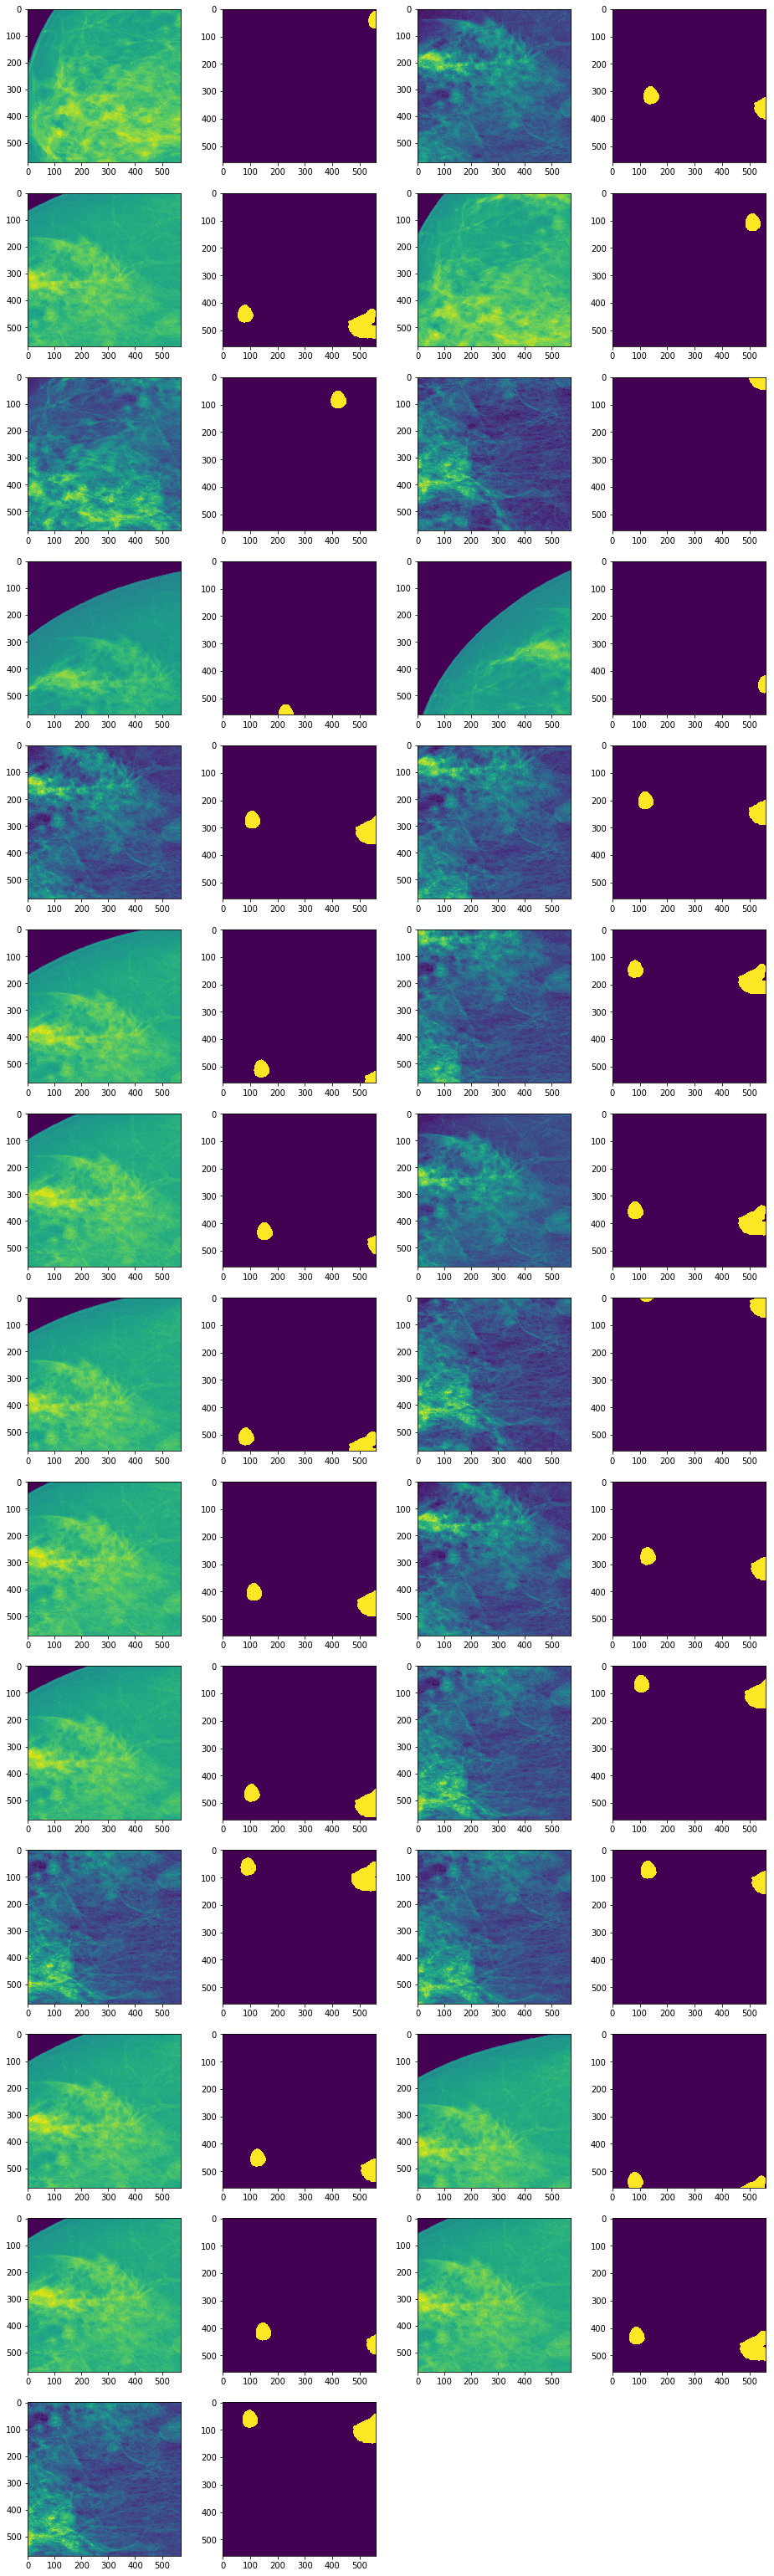

In [27]:
columns = 4
rows = 14
fig=plt.figure(figsize=(columns*4, rows*4))
z =1
for i in range(0, int(columns*rows/2)-1):
    imgp = X[i][0]
    fig.add_subplot(rows, columns, z)
    plt.imshow(imgp)
    z += 1
    imgp = y[i][0]
    fig.add_subplot(rows, columns, z)
    plt.imshow(imgp)
    z += 1
plt.show()

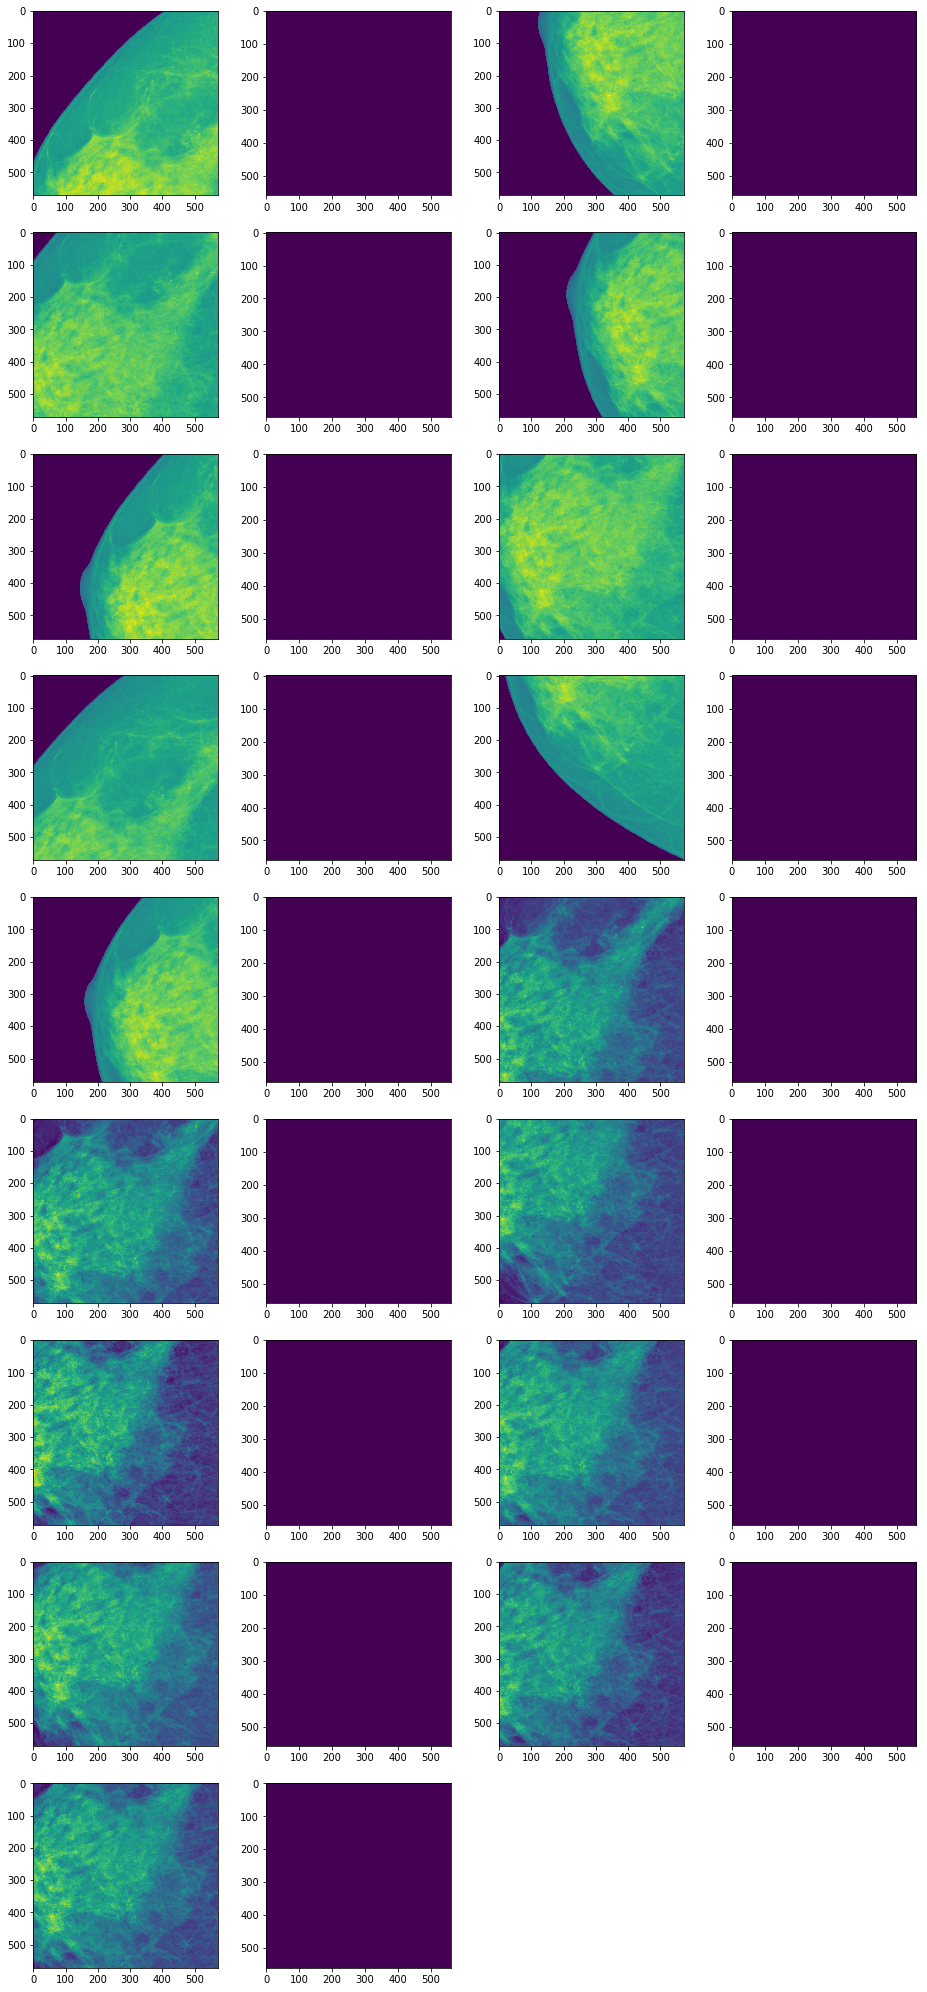

In [28]:
columns = 4
rows = 9
fig=plt.figure(figsize=(columns*4, rows*4))
z =1
for i in range(0, int(columns*rows/2)-1):
    imgp = X_neg[i][0]
    fig.add_subplot(rows, columns, z)
    plt.imshow(imgp)
    z += 1
    imgp = y_neg[i][0]
    fig.add_subplot(rows, columns, z)
    plt.imshow(imgp)
    z += 1
plt.show()

In [43]:
import pickle
import bz2

def save(name, to_save):
    sfile = bz2.BZ2File(name, 'w')
    pickle.dump(to_save, sfile)
    sfile.close()

def load(name):
    sfile = bz2.BZ2File(name, 'rb')
    data = pickle.load(sfile)
    sfile.close()
    return data

In [44]:
save("MassDicomXCrop.bz2", X)
print("X done")
save("MassDicomyCrop.bz2", y)
print("mask done")
save("MassDicomXnegCrop.bz2", X_neg)
print("X_neg done")
save("MassDicomynegCrop.bz2", y_neg)
print("mask_neg done")

X done
mask done
X_neg done
mask_neg done
